In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_excel("rolling_sale_data.xlsx")
print("Kích thước ban đầu:", df.shape)

# Lọc bỏ R* (condo units) ngoại trừ RR (CONDOMINIUM RENTALS)
mask_R  = df["BUILDING CLASS AT TIME OF SALE"].astype(str).str.startswith("R")
mask_RR = df["BUILDING CLASS AT TIME OF SALE"].astype(str).eq("RR")

df = df[~mask_R | mask_RR].copy()

print("Sau khi bỏ R* (trừ RR):", df.shape)
df["BUILDING CLASS AT TIME OF SALE"].value_counts().head()

coop_classes = ["D4", "D0", "C6", "C8", "A8", "CC", "DC", "H7"]
mask_coop = df["BUILDING CLASS AT TIME OF SALE"].astype(str).isin(coop_classes)
df = df[~mask_coop].copy()
print("Sau khi bỏ coop:", df.shape)
df["BUILDING CLASS AT TIME OF SALE"].value_counts().head()



Kích thước ban đầu: (79884, 21)
Sau khi bỏ R* (trừ RR): (58940, 21)
Sau khi bỏ coop: (43196, 21)


BUILDING CLASS AT TIME OF SALE
A1    6506
A5    5295
B1    4543
B2    4412
C0    4185
Name: count, dtype: int64

In [3]:
def evaluate_regression_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    return {
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

## RAW

In [4]:
target_col = "SALE PRICE"

# === 0. Thêm biến thời gian từ SALE DATE ===
df["SALE_MONTH"] = df["SALE DATE"].dt.month              # biến month dùng làm feature
df["SALE_YM"] = df["SALE DATE"].dt.to_period("M").astype(str)   # dùng để split theo thời gian

# === 1. Định nghĩa RAW FEATURES (theo bộ feature mới + SALE_MONTH) ===
raw_features = [
    "TAX CLASS AT TIME OF SALE",
    "BUILDING CLASS CATEGORY",
    "RESIDENTIAL UNITS",
    "COMMERCIAL UNITS",
    "LAND SQUARE FEET",
    "GROSS SQUARE FEET",
    "YEAR BUILT",
    "ZIP CODE",
    "SALE_MONTH",      
]

# DataFrame cho kịch bản RAW
df_raw_scenario = df[raw_features + [target_col, "SALE_YM"]].copy()
# Cột categorical: tax class, building class, zip code
cat_cols_raw = [
    "TAX CLASS AT TIME OF SALE",
    "BUILDING CLASS CATEGORY",
    "ZIP CODE",
]

# Ép kiểu string cho categorical
for c in cat_cols_raw:
    df_raw_scenario[c] = df_raw_scenario[c].astype(str)

# numeric = phần còn lại (bao gồm cả SALE_MONTH)
numeric_cols_raw = [c for c in raw_features if c not in cat_cols_raw]

X_raw = df_raw_scenario[raw_features]
y_raw = df_raw_scenario[target_col]

# === 2. Chia train/test theo 9 tháng đầu tiên (SALE_YM) ===
months_sorted = np.sort(df_raw_scenario["SALE_YM"].unique())
print("Các tháng (YEAR-MONTH) trong dữ liệu:", months_sorted)

train_months = months_sorted[:9]   # 9 tháng đầu của data
test_months  = months_sorted[9:]   # các tháng sau

train_mask = df_raw_scenario["SALE_YM"].isin(train_months)
test_mask  = df_raw_scenario["SALE_YM"].isin(test_months)

X_raw_train = X_raw[train_mask].copy()
X_raw_test  = X_raw[test_mask].copy()
y_raw_train = y_raw[train_mask].copy()
y_raw_test  = y_raw[test_mask].copy()

print("RAW train:", X_raw_train.shape, "RAW test:", X_raw_test.shape)

# === 3. PREPROCESSOR CHO RAW ===
numeric_transformer_raw = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_raw = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_raw = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_raw, numeric_cols_raw),
        ("cat", categorical_transformer_raw, cat_cols_raw),
    ]
)


Các tháng (YEAR-MONTH) trong dữ liệu: ['2024-11' '2024-12' '2025-01' '2025-02' '2025-03' '2025-04' '2025-05'
 '2025-06' '2025-07' '2025-08' '2025-09' '2025-10']
RAW train: (34030, 9) RAW test: (9166, 9)


## Clean

In [5]:
#df_clean = pd.read_csv("df_non_condo_merged.csv").copy()
df_clean = df.copy()
# Bỏ coop
"""coop_classes = ["D4", "D0", "C6", "C8", "A8", "CC", "DC", "H7"]
mask_coop = df_clean["BUILDING CLASS AT TIME OF SALE"].astype(str).isin(coop_classes)
df_clean = df_clean[~mask_coop].copy()
print("Sau khi bỏ coop:", df_clean.shape)
df_clean["BUILDING CLASS AT TIME OF SALE"].value_counts().head()"""

# Lọc target: loại SALE PRICE < 1000
df_clean = df_clean[df_clean[target_col] >= 1000].copy()

# Drop null ZIP CODE (khó imputing hợp lý)
df_clean = df_clean.dropna(subset=["ZIP CODE"]).copy()

# COMMERCIAL UNITS null => 0
df_clean["COMMERCIAL UNITS"] = df_clean["COMMERCIAL UNITS"].fillna(0)

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 23288 entries, 28069 to 79883
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         23288 non-null  int64         
 1   NEIGHBORHOOD                    23288 non-null  object        
 2   BUILDING CLASS CATEGORY         23288 non-null  object        
 3   TAX CLASS AT PRESENT            23288 non-null  object        
 4   BLOCK                           23288 non-null  int64         
 5   LOT                             23288 non-null  int64         
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       23288 non-null  object        
 8   ADDRESS                         23288 non-null  object        
 9   APARTMENT NUMBER                102 non-null    object        
 10  ZIP CODE                        23288 non-null  float64       
 11  RES

In [6]:
target_col = "SALE PRICE"

# SALE DATE -> datetime + biến thời gian
df_clean["SALE DATE"] = pd.to_datetime(df_clean["SALE DATE"])
df_clean["SALE_YEAR"] = df_clean["SALE DATE"].dt.year
df_clean["SALE_MONTH"] = df_clean["SALE DATE"].dt.month
df_clean["SALE_YM"] = df_clean["SALE DATE"].dt.to_period("M").astype(str)

# BUILDING AGE: tuổi tại thời điểm bán = SALE_YEAR - YEAR BUILT
df_clean["BUILDING AGE"] = df_clean["SALE_YEAR"] - df_clean["YEAR BUILT"]

# Nếu tuổi âm (YEAR BUILT > SALE_YEAR) thì cho NaN
df_clean.loc[df_clean["BUILDING AGE"] < 0, "BUILDING AGE"] = np.nan


# === 2. CLEAN FEATURES (theo bộ feature mới + BUILDING AGE + SALE_MONTH) ===
clean_features = [
    "TAX CLASS AT TIME OF SALE",
    "BUILDING CLASS CATEGORY",
    "RESIDENTIAL UNITS",
    "COMMERCIAL UNITS",
    "LAND SQUARE FEET",
    "GROSS SQUARE FEET",
    "YEAR BUILT",
    "BUILDING AGE",       
    "ZIP CODE",
    "SALE_MONTH",   
]

df_clean_scenario = df_clean[clean_features + [target_col, "SALE_YM"]].copy()

# ép categorical về string
cat_cols_clean = [
    "TAX CLASS AT TIME OF SALE",
    "BUILDING CLASS CATEGORY",
    "ZIP CODE",
]
for c in cat_cols_clean:
    df_clean_scenario[c] = df_clean_scenario[c].astype(str)

# numeric là phần còn lại
numeric_cols_clean = [c for c in clean_features if c not in cat_cols_clean]

X_clean = df_clean_scenario[clean_features]
y_clean = df_clean_scenario[target_col]

# === 3. Chia train / test theo thời gian (9 tháng đầu vs các tháng sau) ===
months_sorted = np.sort(df_clean_scenario["SALE_YM"].unique())
print("Các tháng (YEAR-MONTH) trong dữ liệu CLEAN:", months_sorted)

train_months = months_sorted[:9]   # 9 tháng đầu
test_months  = months_sorted[9:]   # còn lại

train_mask = df_clean_scenario["SALE_YM"].isin(train_months)
test_mask  = df_clean_scenario["SALE_YM"].isin(test_months)

X_clean_train = X_clean[train_mask].copy()
X_clean_test  = X_clean[test_mask].copy()
y_clean_train = y_clean[train_mask].copy()
y_clean_test  = y_clean[test_mask].copy()

print("CLEAN train:", X_clean_train.shape, "CLEAN test:", X_clean_test.shape)

# === 4. PREPROCESSOR CHO CLEAN ===
numeric_transformer_clean = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), 
    ("scaler", StandardScaler())
])

categorical_transformer_clean = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_clean = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_clean, numeric_cols_clean),
        ("cat", categorical_transformer_clean, cat_cols_clean),
    ]
)


Các tháng (YEAR-MONTH) trong dữ liệu CLEAN: ['2024-11' '2024-12' '2025-01' '2025-02' '2025-03' '2025-04' '2025-05'
 '2025-06' '2025-07' '2025-08' '2025-09' '2025-10']
CLEAN train: (18010, 10) CLEAN test: (5278, 10)


## model

In [7]:
# Base models (chắc chắn có trong sklearn)
models = {
    # Linear family
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),  # Ridge không có random_state

    # Tree & Ensemble
    "DecisionTree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ),

    # KNN
    "KNN": KNeighborsRegressor(
        n_neighbors=5,
        weights="distance"
    ),

    # Gradient Boosting (sklearn)
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
}

# Thêm CatBoost nếu cài sẵn
try:
    from catboost import CatBoostRegressor
    models["CatBoost"] = CatBoostRegressor(
        loss_function="RMSE",
        depth=8,
        learning_rate=0.03,
        iterations=2000,
        verbose=False
    )
except ImportError:
    print("Chưa cài catboost, bỏ qua CatBoost.")

# Thêm XGBoost nếu cài sẵn
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        objective="reg:squarederror",
    )
except ImportError:
    print("Chưa cài xgboost, bỏ qua XGBoost.")


In [8]:
results = []

# 6.1. RAW
for name, base_model in models.items():
    pipe_raw = Pipeline(steps=[
        ("preprocess", preprocess_raw),
        ("model", base_model)
    ])
    res = evaluate_regression_model(
        name=f"{name}_RAW",
        model=pipe_raw,
        X_train=X_raw_train,
        X_test=X_raw_test,
        y_train=y_raw_train,
        y_test=y_raw_test
    )
    results.append(res)

# 6.2. CLEAN
for name, base_model in models.items():
    pipe_clean = Pipeline(steps=[
        ("preprocess", preprocess_clean),
        ("model", base_model)
    ])
    res = evaluate_regression_model(
        name=f"{name}_CLEAN",
        model=pipe_clean,
        X_train=X_clean_train,
        X_test=X_clean_test,
        y_train=y_clean_train,
        y_test=y_clean_test
    )
    results.append(res)

results_df = pd.DataFrame(results).sort_values("MAE")
results_df


,model,MAE,RMSE,R2
6,CatBoost_RAW,1.741090e+06,4.860414e+14,0.084485
3,RandomForest_RAW,1.747742e+06,4.752230e+14,0.104863
7,XGBoost_RAW,1.764844e+06,4.703158e+14,0.114106
5,GradientBoosting_RAW,1.768364e+06,4.753878e+14,0.104553
4,KNN_RAW,1.773162e+06,4.594018e+14,0.134664
2,DecisionTree_RAW,1.773270e+06,5.216696e+14,0.017376
1,Ridge_RAW,1.850742e+06,4.783269e+14,0.099017
0,LinearRegression_RAW,1.850788e+06,4.799569e+14,0.095946
14,CatBoost_CLEAN,2.081419e+06,8.125236e+14,0.114672
15,XGBoost_CLEAN,2.082475e+06,7.473724e+14,0.185661


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử results_df đã có rồi
df_plot = results_df.copy()

# Tách "LinearRegression_RAW" -> base_model="LinearRegression", scenario="RAW/CLEAN"
df_plot[["base_model", "scenario"]] = df_plot["model"].str.rsplit("_", n=1, expand=True)

# Sắp xếp thứ tự model cho đẹp
order_models = ["LinearRegression", "Ridge", "KNN", "DecisionTree", "RandomForest", "GradientBoosting", "XGBoost","CatBoost"]
df_plot["base_model"] = pd.Categorical(df_plot["base_model"], categories=order_models, ordered=True)

df_plot = df_plot.sort_values(["base_model", "scenario"])
df_plot


,model,MAE,RMSE,R2,base_model,scenario
8,LinearRegression_CLEAN,2.343655e+06,7.809783e+14,0.149044,LinearRegression,CLEAN
0,LinearRegression_RAW,1.850788e+06,4.799569e+14,0.095946,LinearRegression,RAW
9,Ridge_CLEAN,2.357808e+06,7.774587e+14,0.152879,Ridge,CLEAN
1,Ridge_RAW,1.850742e+06,4.783269e+14,0.099017,Ridge,RAW
12,KNN_CLEAN,2.125731e+06,7.544699e+14,0.177928,KNN,CLEAN
4,KNN_RAW,1.773162e+06,4.594018e+14,0.134664,KNN,RAW
10,DecisionTree_CLEAN,2.180019e+06,7.533112e+14,0.179190,DecisionTree,CLEAN
2,DecisionTree_RAW,1.773270e+06,5.216696e+14,0.017376,DecisionTree,RAW
11,RandomForest_CLEAN,2.109536e+06,7.805734e+14,0.149485,RandomForest,CLEAN
3,RandomForest_RAW,1.747742e+06,4.752230e+14,0.104863,RandomForest,RAW


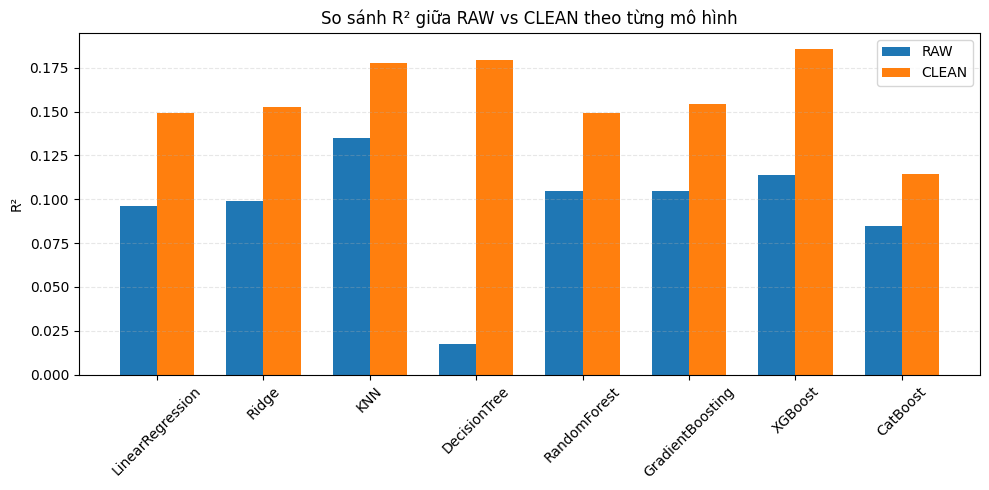

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

width = 0.35
x = range(len(order_models))

r2_raw = []
r2_clean = []

for m in order_models:
    r2_raw.append(df_plot[(df_plot["base_model"] == m) & (df_plot["scenario"] == "RAW")]["R2"].values[0])
    r2_clean.append(df_plot[(df_plot["base_model"] == m) & (df_plot["scenario"] == "CLEAN")]["R2"].values[0])

ax.bar([i - width/2 for i in x], r2_raw, width=width, label="RAW")
ax.bar([i + width/2 for i in x], r2_clean, width=width, label="CLEAN")

ax.set_xticks(list(x))
ax.set_xticklabels(order_models, rotation=45)
ax.set_ylabel("R²")
ax.set_title("So sánh R² giữa RAW vs CLEAN theo từng mô hình")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


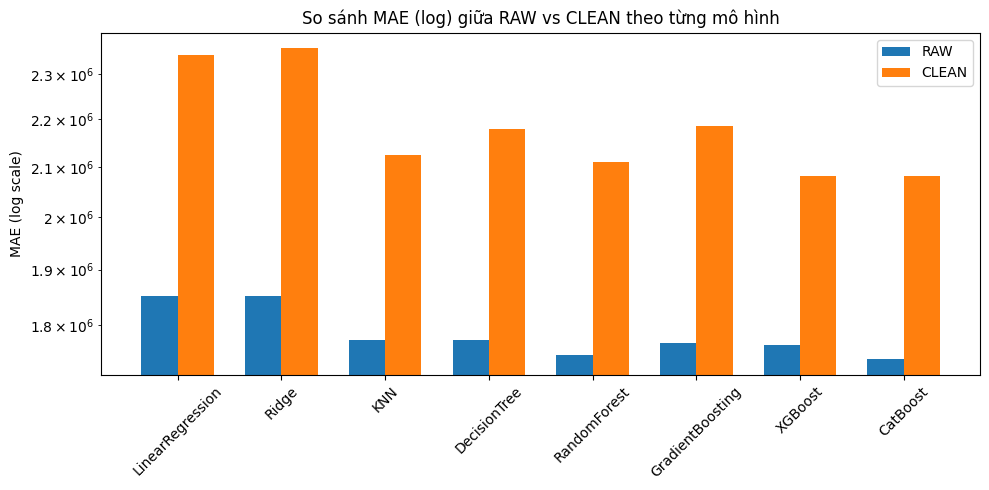

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))

width = 0.35
x = range(len(order_models))

mae_raw = []
mae_clean = []

for m in order_models:
    mae_raw.append(df_plot[(df_plot["base_model"] == m) & (df_plot["scenario"] == "RAW")]["MAE"].values[0])
    mae_clean.append(df_plot[(df_plot["base_model"] == m) & (df_plot["scenario"] == "CLEAN")]["MAE"].values[0])

ax.bar([i - width/2 for i in x], mae_raw, width=width, label="RAW")
ax.bar([i + width/2 for i in x], mae_clean, width=width, label="CLEAN")

ax.set_xticks(list(x))
ax.set_xticklabels(order_models, rotation=45)
ax.set_yscale("log")
ax.set_ylabel("MAE (log scale)")
ax.set_title("So sánh MAE (log) giữa RAW vs CLEAN theo từng mô hình")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


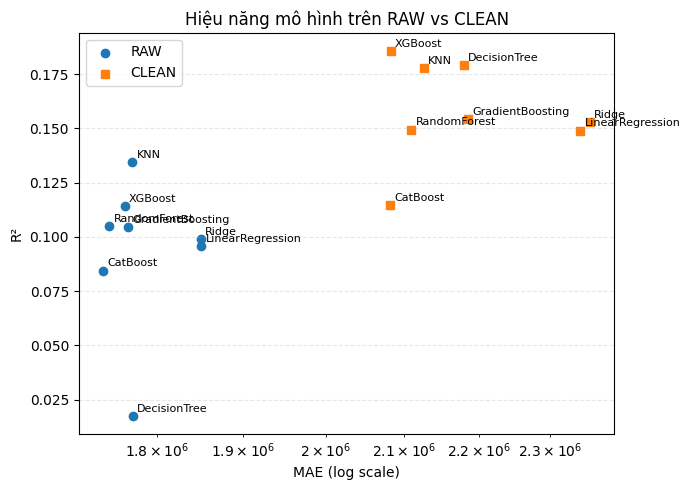

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))

for scenario, marker in [("RAW", "o"), ("CLEAN", "s")]:
    sub = df_plot[df_plot["scenario"] == scenario]
    ax.scatter(sub["MAE"], sub["R2"], marker=marker, label=scenario)
    # gắn nhãn tên model
    for _, row in sub.iterrows():
        ax.annotate(row["base_model"], (row["MAE"], row["R2"]), fontsize=8, xytext=(3,3), textcoords="offset points")

ax.set_xscale("log")
ax.set_xlabel("MAE (log scale)")
ax.set_ylabel("R²")
ax.set_title("Hiệu năng mô hình trên RAW vs CLEAN")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()
